In [1]:
# Data wrangling
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf

from collections import Counter
import ast # used for converting string lists to lists with string elements

## import Sofies data

In [2]:
# Load cleaned datasets
movie_metadata = pd.read_csv('data_cleaned/movie_cleaned.csv', lineterminator='\n')
character_metadata = pd.read_csv('data_cleaned/character_cleaned.csv')

for i in [movie_metadata, character_metadata]:
    i.columns = i.columns.str.replace(' ', '_')
    i.fillna(0, inplace=True)

In [3]:
print("MOVIE DATA COLUMNS:\n",movie_metadata.columns,"\n\n","CHARACTER DATA COLUMNS:\n",character_metadata.columns)
print(character_metadata.shape, movie_metadata.shape)

MOVIE DATA COLUMNS:
 Index(['Unnamed:_0.1', 'Unnamed:_0', 'Wikipedia_Movie_ID', 'Freebase_Movie_ID',
       'Movie_name', 'Movie_release_date', 'Movie_runtime', 'Movie_languages',
       'Movie_countries', 'Movie_genres', 'TMDB_id', 'TMDB_original_language',
       'TMDB_original_title', 'TMDB_overview', 'TMDB_popularity',
       'TMDB_release_date', 'TMDB_title', 'TMDB_vote_average',
       'TMDB_vote_count', 'TMDB_runtime', 'TMDB_budget', 'TMDB_IMDB_id',
       'TMDB_genres', 'Movie_box_office_revenue', 'Movie_release_year',
       'log_Movie_box_office_revenue', 'log_Movie_release_year',
       'log_TMDB_vote_count', 'Male_actor_percentage',
       'Mean_actor_age_at_movie_release', 'balanced_Movie_box_office_revenue',
       'log_balanced_Movie_box_office_revenue'],
      dtype='object') 

 CHARACTER DATA COLUMNS:
 Index(['Unnamed:_0.1', 'Unnamed:_0', 'Wikipedia_Movie_ID', 'Freebase_Movie_ID',
       'Movie_release_date', 'Character_name', 'Actor_DOB', 'Actor_gender',
       'Actor

# Regression

In [6]:
movie_reg_data = movie_metadata[['Movie_runtime', 'TMDB_original_language', 'Movie_countries', 'Movie_genres', 'Movie_release_year', 
                                          'log_TMDB_vote_count', 'log_balanced_Movie_box_office_revenue', 'TMDB_vote_average', 
                                          'Male_actor_percentage', 'Mean_actor_age_at_movie_release']]
numeric_columns = movie_reg_data.select_dtypes(include=['number']).columns.tolist()
numeric_data = movie_reg_data[numeric_columns]
# Print the list of numeric columns
print(numeric_columns)

['Movie_runtime', 'Movie_release_year', 'log_TMDB_vote_count', 'log_balanced_Movie_box_office_revenue', 'TMDB_vote_average', 'Male_actor_percentage', 'Mean_actor_age_at_movie_release']


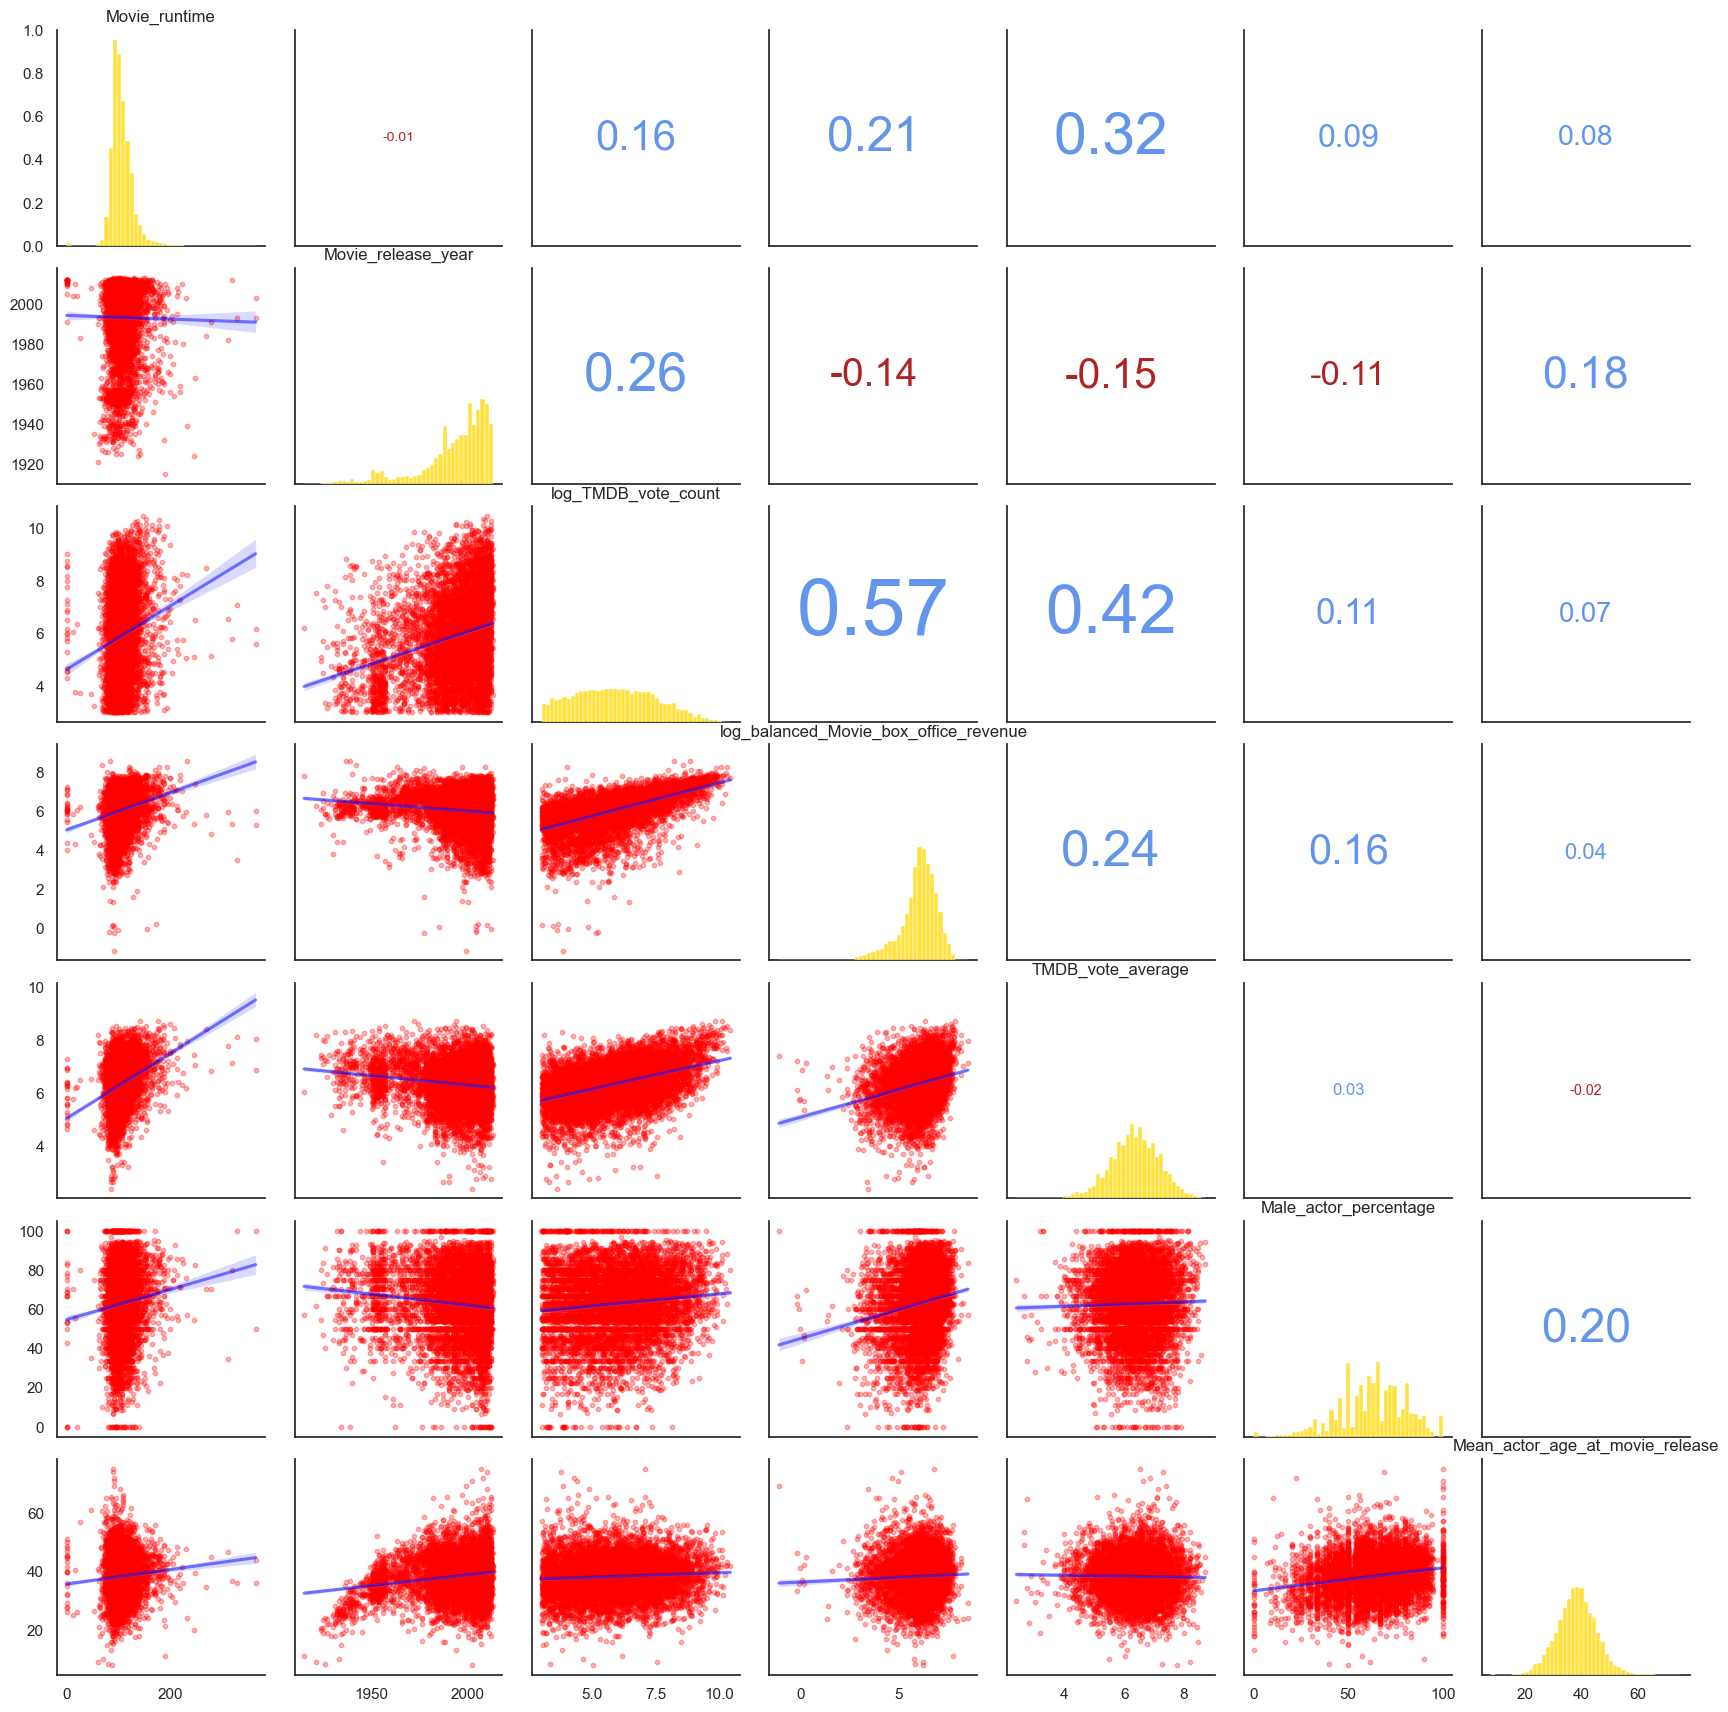

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import numpy as np

# Define the function for correlation
def corr_func(x, y, **kwargs):
    r = pearsonr(x, y)[0]
    ax = plt.gca()
    size = np.sqrt(np.abs(r)) * 75  # Non-linear scaling for size
    color = 'cornflowerblue' if r > 0 else 'firebrick'  # Blue for positive, red for negative
    ax.annotate(f"{r:.2f}", xy=(.5, .5), xycoords=ax.transAxes, 
                size=max(size, 10),  # Minimum size to ensure readability
                ha='center', va='center', color=color)

# Define the function to label diagonal plots
def label_diag(x, **kwargs):
    ax = plt.gca()
    ax.set_title(x.name)  # Set the title to the variable name

# Assuming numeric_data is defined
# Create an empty pairgrid with a custom color palette
sns.set(style="white", palette="husl")
grid = sns.PairGrid(numeric_data)

# Map the plots to the lower, upper, and diagonal elements of the pairgrid
grid = grid.map_upper(corr_func)  # Annotate correlation coefficients
grid = grid.map_lower(sns.regplot, scatter_kws={'color':'red','s': 10, 'alpha': 0.3}, line_kws={'color':'blue','alpha': 0.5})
grid = grid.map_diag(sns.histplot, color='gold', bins=45)  # Histograms
grid = grid.map_diag(label_diag)  # Label the diagonal with variable names

# Remove axis labels for x and y axes
for ax in grid.axes.flatten():
    ax.set_xlabel('')
    ax.set_ylabel('')

# Save the plot with high DPI
plt.savefig(fname="plots/BOBsYndlingsPlot.png", dpi=1000)
plt.show()

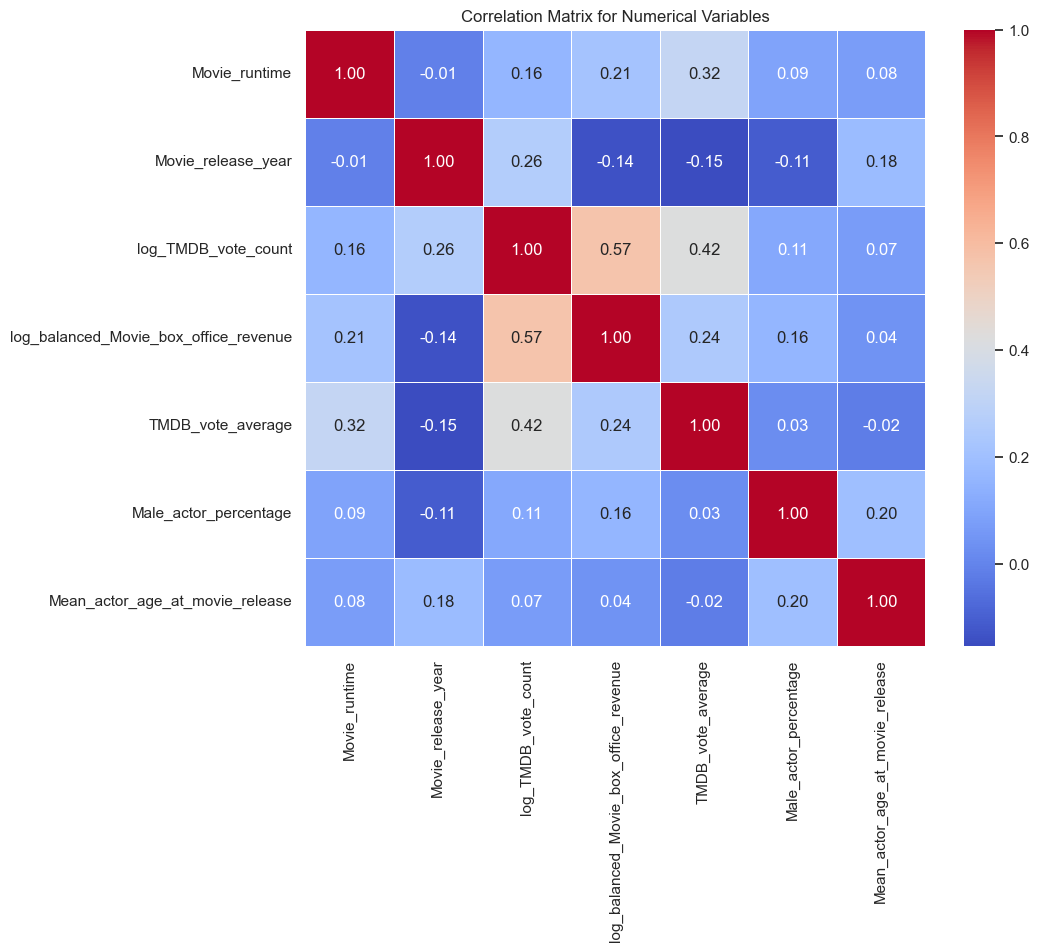

In [21]:
# Creating the correlation matrix
corr_matrix = movie_reg_data[numeric_columns].corr()

# Plotting the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Correlation Matrix for Numerical Variables')
plt.savefig(fname="plots/Correlation_matrix_numerical_variables.png", dpi=1000, bbox_inches='tight')
plt.show()

In [9]:
# Convert to list: ast.literal_eval("['Thriller', 'Horror']) will output the list ['Thriller', 'Horror']
categorical__toDummy_columns = ['Movie_countries', 'Movie_genres']

for column in categorical__toDummy_columns:
    print(movie_reg_data[column][0],"\n", type(movie_reg_data[column][0]))
    movie_reg_data.loc[:, column] = movie_reg_data[column].apply(lambda x: ast.literal_eval(x))

print(movie_reg_data[categorical__toDummy_columns])

['United States of America'] 
 <class 'str'>
['Thriller', 'Science Fiction', 'Horror', 'Adventure', 'Supernatural', 'Action', 'Space western'] 
 <class 'str'>
                                        Movie_countries  \
0                            [United States of America]   
1                                      [United Kingdom]   
2                            [United States of America]   
3                            [United States of America]   
4               [United States of America, Netherlands]   
...                                                 ...   
7558  [Kingdom of Great Britain, Japan, England, Uni...   
7559                         [United States of America]   
7560                         [United States of America]   
7561                 [France, United States of America]   
7562                         [United States of America]   

                                           Movie_genres  
0     [Thriller, Science Fiction, Horror, Adventure,...  
1     [Costume d

In [10]:
# Check if converted to list
for column in categorical__toDummy_columns:
    print(movie_reg_data[column][0],"\n", type(movie_reg_data[column][0]))

['United States of America'] 
 <class 'list'>
['Thriller', 'Science Fiction', 'Horror', 'Adventure', 'Supernatural', 'Action', 'Space western'] 
 <class 'list'>


In [11]:
all_genres = {}
all_countries = {}

for col in categorical__toDummy_columns:
    for list_element in movie_reg_data[col]:
        # Iterate over each element in the list
        for element in list_element:
            # Increment the count for the element in the respective dictionary
            if col == 'Movie_countries':
                all_countries[element] = all_countries.get(element, 0) + 1
            elif col == 'Movie_genres':
                all_genres[element] = all_genres.get(element, 0) + 1

# Print the top N genres with the highest occurrences for each column
for occurrence_dict, column_name in zip([all_genres, all_countries], categorical__toDummy_columns):
    n = 10
    # Get the top N items with the highest occurrences (in descending order)
    top_n = sorted(occurrence_dict.items(), key=lambda x: x[1], reverse=True)[:n]

    print(f"\n\nTop {n} {column_name} with the highest occurrences:")
    for i, count in top_n:
        print(f"{i}: {count} occurrences")



Top 10 Movie_countries with the highest occurrences:
Drama: 3779 occurrences
Comedy: 2886 occurrences
Thriller: 1989 occurrences
Romance Film: 1733 occurrences
Action: 1717 occurrences
Action/Adventure: 1349 occurrences
Crime Fiction: 1222 occurrences
Adventure: 1099 occurrences
Indie: 893 occurrences
Family Film: 807 occurrences


Top 10 Movie_genres with the highest occurrences:
United States of America: 5990 occurrences
United Kingdom: 931 occurrences
France: 497 occurrences
Germany: 453 occurrences
Canada: 303 occurrences
Japan: 204 occurrences
Italy: 183 occurrences
Australia: 164 occurrences
South Korea: 161 occurrences
Spain: 124 occurrences


In [12]:
formula_revenue = 'log_balanced_Movie_box_office_revenue ~ C(TMDB_original_language)'
formula_rating = 'TMDB_vote_average ~ C(TMDB_original_language)'

for col in numeric_columns:
    if col not in ['log_balanced_Movie_box_office_revenue','TMDB_vote_average']:
        formula_revenue += '+' + col
        formula_rating += '+' + col
print(formula_revenue, formula_rating)

log_balanced_Movie_box_office_revenue ~ C(TMDB_original_language)+Movie_runtime+Movie_release_year+log_TMDB_vote_count+Male_actor_percentage+Mean_actor_age_at_movie_release TMDB_vote_average ~ C(TMDB_original_language)+Movie_runtime+Movie_release_year+log_TMDB_vote_count+Male_actor_percentage+Mean_actor_age_at_movie_release


In [13]:
# top n occurring elements in categorical columns
n = 10
print(movie_reg_data.shape)
for col in categorical__toDummy_columns:
    # Flatten the lists, handling NaN values
    flattened_values = [item for sublist in movie_reg_data[col].apply(lambda x: x if isinstance(x, list) else []).dropna() for item in sublist]

    # Count occurrences of each element
    element_counts = pd.Series(flattened_values).value_counts()

    # Select the top 10 most occurring elements
    top_elements = element_counts.head(n).index.tolist()

    # Create dummy variables only for the top 10 elements
    dummy_variables = pd.get_dummies(pd.Series(flattened_values).apply(lambda x: x if x in top_elements else 'Other'))

    # Rename the dummy columns to avoid conflicts
    dummy_variables.columns = dummy_variables.columns.str.replace(' ', '_').str.replace('-', '_').str.replace('/', '_')
    dummy_variables.columns = [f"{col}_{element}" for element in dummy_variables.columns]
    
    # Reset index before concatenation
    movie_reg_data = movie_reg_data.reset_index(drop=True)
    
    # Add dummy variables to the formula
    formula_revenue += ' + ' + ' + '.join(dummy_variables.columns)
    formula_rating += ' + ' + ' + '.join(dummy_variables.columns)
    
    # Merge the dummy variables with the original DataFrame
    movie_reg_data = pd.merge(movie_reg_data, dummy_variables, left_index=True, right_index=True)

print(formula_revenue,
     "\n\n", formula_rating, dummy_variables.shape, movie_reg_data.shape)

(7301, 10)
log_balanced_Movie_box_office_revenue ~ C(TMDB_original_language)+Movie_runtime+Movie_release_year+log_TMDB_vote_count+Male_actor_percentage+Mean_actor_age_at_movie_release + Movie_countries_Australia + Movie_countries_Canada + Movie_countries_France + Movie_countries_Germany + Movie_countries_Italy + Movie_countries_Japan + Movie_countries_Other + Movie_countries_South_Korea + Movie_countries_Spain + Movie_countries_United_Kingdom + Movie_countries_United_States_of_America + Movie_genres_Action + Movie_genres_Action_Adventure + Movie_genres_Adventure + Movie_genres_Comedy + Movie_genres_Crime_Fiction + Movie_genres_Drama + Movie_genres_Family_Film + Movie_genres_Indie + Movie_genres_Other + Movie_genres_Romance_Film + Movie_genres_Thriller 

 TMDB_vote_average ~ C(TMDB_original_language)+Movie_runtime+Movie_release_year+log_TMDB_vote_count+Male_actor_percentage+Mean_actor_age_at_movie_release + Movie_countries_Australia + Movie_countries_Canada + Movie_countries_France + Mo

In [14]:
print(movie_reg_data.shape, movie_metadata.shape)

(7301, 32) (7301, 32)


In [15]:
# Setup models
model_revenue = smf.ols(formula=formula_revenue, data=movie_reg_data)
model_rating = smf.ols(formula=formula_rating, data=movie_reg_data)

In [16]:
np.random.seed(2)

# Fit the model
res_revenue = model_revenue.fit()
res_rating = model_rating.fit()

print(res_revenue.summary(),
      res_rating.summary())

                                      OLS Regression Results                                     
Dep. Variable:     log_balanced_Movie_box_office_revenue   R-squared:                       0.454
Model:                                               OLS   Adj. R-squared:                  0.449
Method:                                    Least Squares   F-statistic:                     100.2
Date:                                   Wed, 20 Dec 2023   Prob (F-statistic):               0.00
Time:                                           16:11:08   Log-Likelihood:                -7818.1
No. Observations:                                   7301   AIC:                         1.576e+04
Df Residuals:                                       7240   BIC:                         1.618e+04
Df Model:                                             60                                         
Covariance Type:                               nonrobust                                         
                    

                                                  Coefficient        P-Value  \
C(TMDB_original_language)[T.da]                     -1.202045   3.777511e-03   
C(TMDB_original_language)[T.de]                     -0.950496   1.173678e-02   
C(TMDB_original_language)[T.el]                     -1.575348   1.052783e-02   
C(TMDB_original_language)[T.fa]                     -1.632827   2.625296e-03   
C(TMDB_original_language)[T.hu]                     -2.832535   4.143302e-06   
C(TMDB_original_language)[T.it]                     -0.747069   4.271413e-02   
C(TMDB_original_language)[T.no]                     -1.161037   2.077629e-02   
C(TMDB_original_language)[T.ro]                     -1.292525   3.560861e-02   
C(TMDB_original_language)[T.sr]                     -1.121647   3.867212e-02   
C(TMDB_original_language)[T.sv]                     -0.909400   2.536855e-02   
C(TMDB_original_language)[T.te]                     -2.432181   7.753825e-05   
Movie_countries_Australia[T.True]       

C:\Users\kavus\AppData\Local\Temp\ipykernel_12332\3570292347.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Coefficient', y='Name', data=significant_coeff_df, palette='viridis')


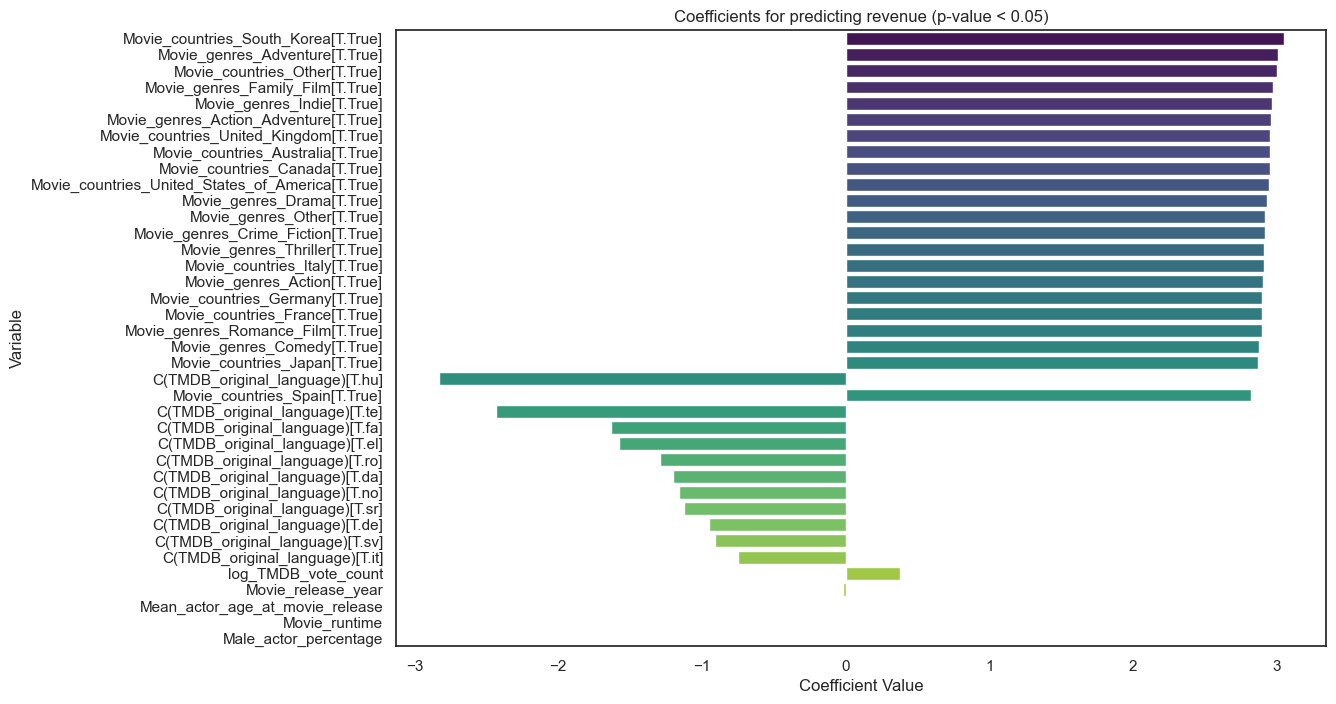

                                                  Coefficient        P-Value  \
C(TMDB_original_language)[T.cn]                     -0.657008   4.574317e-02   
C(TMDB_original_language)[T.de]                     -0.696603   3.759192e-02   
C(TMDB_original_language)[T.en]                     -1.325963   2.748068e-05   
C(TMDB_original_language)[T.fi]                     -0.911840   3.129102e-02   
C(TMDB_original_language)[T.fr]                     -0.779292   1.482469e-02   
C(TMDB_original_language)[T.hi]                     -1.006121   1.992936e-03   
C(TMDB_original_language)[T.it]                     -0.887251   6.745307e-03   
C(TMDB_original_language)[T.ru]                     -0.847710   1.635201e-02   
C(TMDB_original_language)[T.tr]                     -1.066886   2.052804e-03   
Movie_countries_Australia[T.True]                    2.998882  9.158413e-211   
Movie_countries_Canada[T.True]                       3.012993  4.794844e-245   
Movie_countries_France[T.True]          

C:\Users\kavus\AppData\Local\Temp\ipykernel_12332\3570292347.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Coefficient', y='Name', data=significant_coeff_df, palette='viridis')


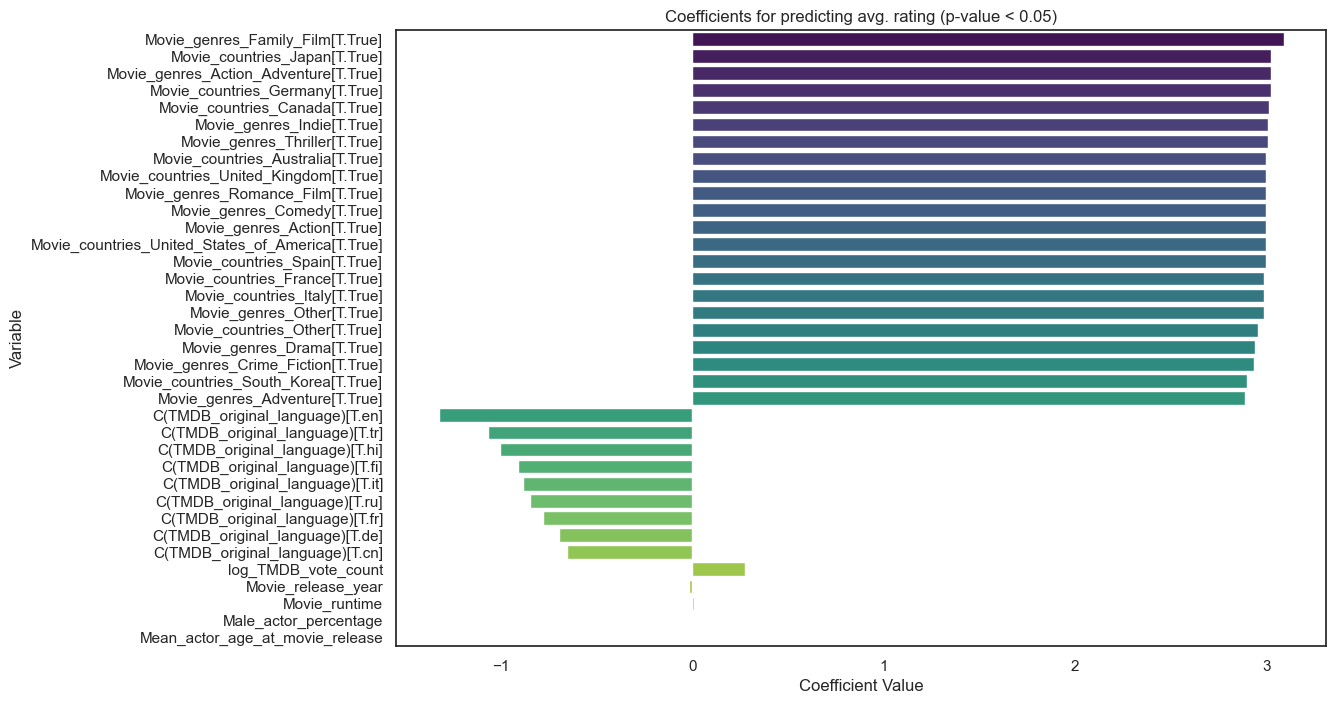

In [17]:
for res in [res_revenue, res_rating]:
# Extract
    coefficients = res.params
    p_values = res.pvalues
    coeff_names = coefficients.index

    # Create a DataFrame for better plotting
    coeff_df = pd.DataFrame({'Coefficient': coefficients, 'P-Value': p_values, 'Name': coeff_names})

    # Exclude the intercept from the DataFrame
    coeff_df = coeff_df[coeff_df['Name'] != 'Intercept']

    # Filter coefficients with p-value < 0.05
    significant_coeff_df = coeff_df[coeff_df['P-Value'] < 0.05]
    print(significant_coeff_df)
    # Sort coefficients by magnitude for better visualization
    significant_coeff_df = significant_coeff_df.reindex(significant_coeff_df['Coefficient'].abs().sort_values(ascending=False).index)

    # Plot significant coefficients
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Coefficient', y='Name', data=significant_coeff_df, palette='viridis')
    plt.xlabel('Coefficient Value')
    plt.ylabel('Variable')
    if res == res_revenue:
        plt.title('Coefficients for predicting revenue (p-value < 0.05)')
        plt.savefig(fname="plots/Coefficients_revenue_model.png",dpi=1000)
    else:
        plt.title('Coefficients for predicting avg. rating (p-value < 0.05)')
        plt.savefig(fname="plots/Coefficients_rating_model.png",dpi=1000)
    plt.show()

In [19]:
movie_reg_data.shape

(7301, 32)

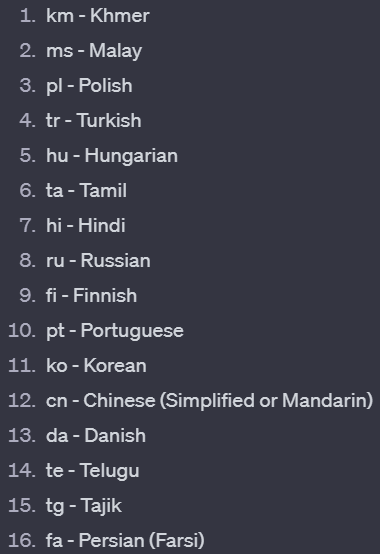

# OUTDATED!!!

All the coefficients are significant on a 5% significance level. To asses how they contribute to the dependent variables Revenue and Rating, the coefficients will be interpreted in the two models.

## Results for log_Movie_box_office_revenue:

**Top Negative Predictors:**
1. Movie_genres_Action_Adventure: -1.89
2. Movie_genres_Crime_Fiction: -1.72
3. Movie_genres_Action: -1.70
4. Movie_genres_Adventure: -1.56
5. Movie_genres_Other: -1.56

Movies in Action, Adventure, and related genres tend to have a negative impact on the log of box office revenue.

**Top Positive Predictors:**
1. Movie_runtime: 0.027
2. Movie_release_year: 0.018
3. Movie_genres_Indie: 0.95
4. Movie_genres_Romance_Film: 0.84
5. Movie_genres_Drama: 0.70

An increase in runtime and release year is associated with an increase in the log of box office revenue. Also, Indie, Romance, and Drama genres have a positive impact.

## Results for TMDB_vote_average:

**Top Positive Predictors:**
1. Movie_genres_Other: 1.00
2. Movie_genres_Action: 0.95
3. Movie_genres_Romantic_comedy: 0.85
4. Movie_genres_Comedy: 0.98
5. Movie_genres_Romance_Film: 0.95

Movies in various genres, especially Other, Action, Romantic comedy, Comedy, and Romance, tend to have higher average vote ratings.

**Top Negative Predictor:**
- Movie_release_year: -0.004

More recent movies have slightly lower vote averages on TMDB.

## Similarities and Differences:

**Similarities:**
- Both models include similar genres as significant predictors, such as Action, Adventure, Comedy, and Drama.
- Movie_runtime is a common positive predictor in both models, influencing box office revenue positively and vote average negatively.

**Differences:**
- The impact of genres on revenue is negative, while on vote average, it can be positive (e.g., Romantic comedy, Indie, etc.).
- Movie_release_year has a positive impact on revenue but a negative impact on vote average.

In summary, genres, runtime, and release year play crucial roles in predicting box office revenue and vote average, and their impact can differ between the two outcomes.